In [1]:
import pandas as pd
import numpy as np

In [2]:
from literacy_score.grade import DataGrader, grade_wcpm
from literacy_score.train import ModelTrainer
from literacy_score.config import SEED

## 1. Open Data

In [3]:
df = pd.read_csv("./data/larger_wcpm.csv")

## 2. Predict grades based on already trained models

## 3. Train a model

Instanciate ModelTrainer and preprocess the data. You have to choose several parameters that are all listed here. You have to choose between Random Forest ('RF'), XGBoost('XGB') and K nearest neighbors ('KNN'). You will be able to change it after without re processing the data using the set_new_model(model_type, params) method.

In [83]:
config = {
    'model_type': 'XGB',
    'remove_outliers': True,
    'outliers_tol': .15,
    'test_set_size': .2,
    'seed': SEED
}
trainer = ModelTrainer(df,
                       model_type = config['model_type']
                      )
trainer.compute_features()
trainer.prepare_train_test_set(remove_outliers = config['remove_outliers'],
                               outliers_tol = config['outliers_tol'],
                               test_set_size = config['test_set_size'],
                               inplace = True
                              )

2020-10-06 19:57:40,988 root         INFO     Removed 166 outliers, 2876 datapoints remaining for training/testing


Take a look at the features used to estimate the wcpm (after standard scaling), plus label 'human_wc':

In [84]:
trainer.features.describe()

,correct_words,added_words,removed_words,replaced_words,asr_word_count,prompt_avg_word_length,prompt_std_word_length,asr_avg_word_length,asr_std_word_length,human_wc
count,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000
mean,103.672114,9.239221,10.798679,3.647079,113.145688,4.217915,1.969704,4.129150,1.882962,105.027557
std,40.758554,6.599273,23.746476,3.635515,42.061991,0.513844,0.369361,0.536421,0.359985,41.624688
min,0.000000,0.000000,0.000000,0.000000,1.000000,2.357000,0.667000,2.000000,0.000000,0.000000
25%,80.000000,5.000000,2.000000,1.000000,92.000000,4.040000,1.855000,3.914750,1.691750,81.000000
50%,111.000000,8.000000,4.000000,3.000000,121.000000,4.258000,1.993000,4.179000,1.935000,112.000000
75%,133.000000,13.000000,9.000000,5.000000,142.000000,4.523000,2.229000,4.440000,2.114250,134.000000
max,211.000000,78.000000,219.000000,41.000000,253.000000,5.207000,2.757000,5.429000,2.985000,259.000000


#### Now, let's train the model and evaluate it's performances on the test set

In [7]:
trainer.train()

2020-10-06 15:39:59,860 root         INFO     Training XGB


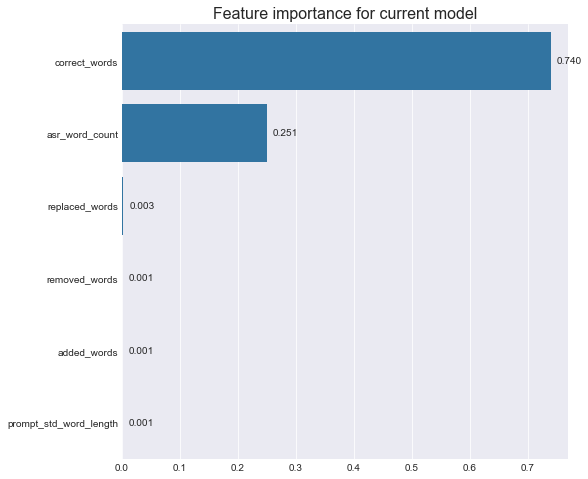

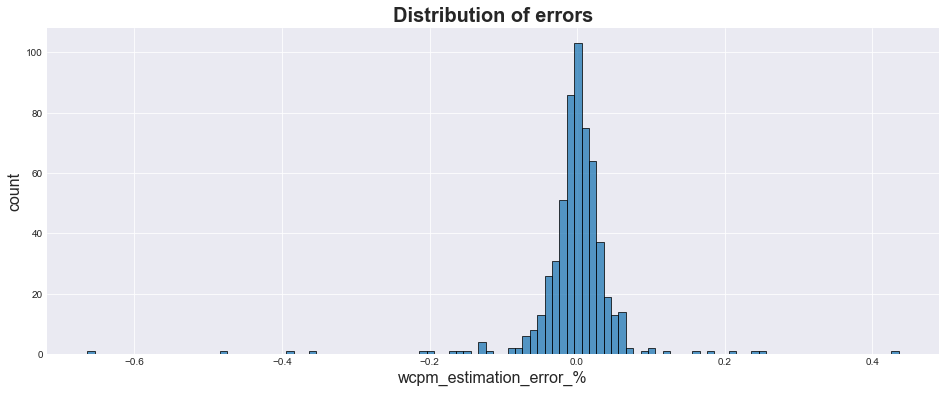

In [8]:
trainer.feature_importance()
stats, summary = trainer.evaluate_model(visualize = True)

#### Now we want to train another model, but without having to redo the preprocesssing: we can use self.set_new_model()

2020-10-06 20:01:45,281 root         INFO     Training XGB


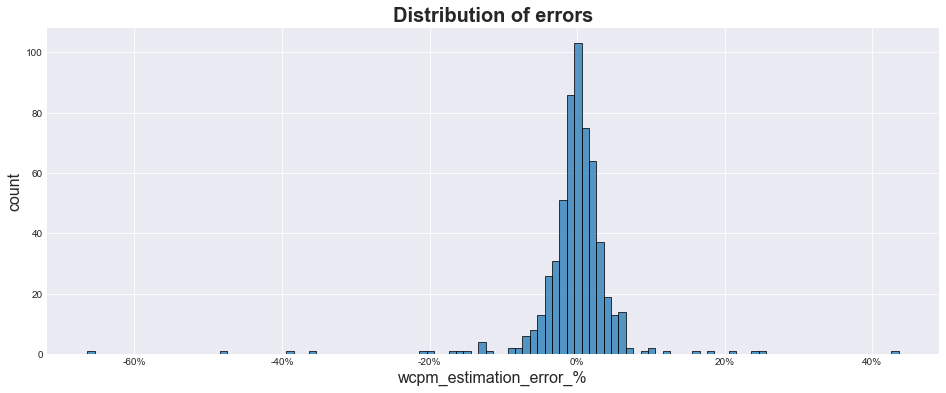

In [91]:
params = {'n_estimators': 5000,
          'learning_rate': 0.02,
          'max_depth': 7,
          'subsample': 0.81,
          'colsample_bytree': 0.86,
          'gamma': 5
         }

# params = {'n_neighbors': 6,
#           'weights': 'distance'
#          }

# params = {'max_features': 6,
#           'n_estimators': 200,
#           'max_depth': 20,
#           'min_samples_split': 8,
#           'min_samples_leaf': 2,
#           'bootstrap': True
#          }

trainer.set_new_model(model_type = 'XGB',
#                       params = params
                     )
trainer.train()
# trainer.feature_importance(threshold = 0)
stats, summary = trainer.evaluate_model(visualize = True)

,Mean Error,Mean Error %,Mean abs. Error,Mean abs. Error %,RMSE,Error > 1%,Error > 5%,Error > 10%
mean,0.21,-0.00,2.60,2.89,4.73,NaN,NaN,NaN
std,4.73,0.06,3.95,5.22,12.41,NaN,NaN,NaN
absolute #,NaN,NaN,NaN,NaN,NaN,386.00,69.00,22.00
% of test set,NaN,NaN,NaN,NaN,NaN,67.01,11.98,3.82


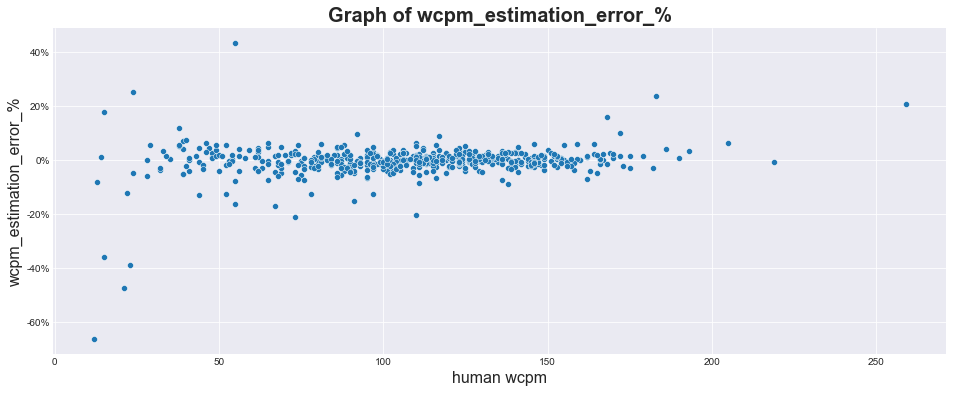

In [92]:
trainer.plot_wcpm_scatter(stats, y = 'wcpm_estimation_error_%')
summary

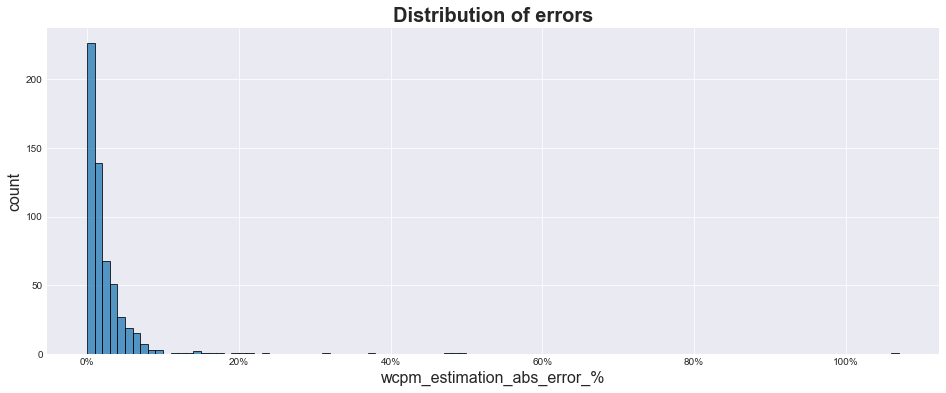

In [88]:
trainer.plot_wcpm_distribution(stats, x='wcpm_estimation_abs_error_%', binwidth=.01)

## 4. Grid search

In [76]:
# RandomForestRegressor
cv_params={
#     'max_features': np.arange(1, 9, 1),
    'max_features': [6],
#     'n_estimators': list(np.arange(100, 2000, 100)),
    'n_estimators': [200],
#     'max_depth': np.arange(5, 120, 5),
    'max_depth': [20],
    'min_samples_split': np.arange(1, 15, 1),
    'min_samples_split': [8],
#     'min_samples_leaf': np.arange(1, 6, 1)
    'min_samples_leaf': [2],
    'bootstrap': [True]
}

# XGBoostRegressors
# cv_params = {
#     'n_estimators': list(np.arange(100, 2001, 100)),
# #     'n_estimators': [500],
#     'learning_rate': np.arange(0.0, 0.101, 0.005),
# #     'learning_rate': [0.01, 0.02, 0.04, 0.05, 0.1],
# #     'learning_rate': [0.02],
# #     'max_depth': np.arange(3, 26, 1)
#     'max_depth': [7],
# #     'subsample': np.arange(0.8, 1, 0.01)
#     'subsample': [0.81],
# #     'colsample_bytree': np.arange(0.3, 1, 0.02),
#     'colsample_bytree': [0.86],
# #     'gamma': [0, 1, 5]
#     'gamma': [5]
# }

# KNN
# cv_params = {
#     "n_neighbors": np.arange(1, 30, 1),
#     'weights': ['uniform', 'distance']
# }

In [77]:
gd = trainer.grid_search(model_type = 'RF',
                         cv_params=cv_params,
                         cv_folds=5,
                         scoring_metric = 'r2',
                         verbose = 5
                        )





------------------------------------------------------ Estimator: ------------------------------------------------------
RandomForestRegressor

------------------------------------------------ Metric for evaluation: ------------------------------------------------
r2

---------------------------------------------------- Fixed params: -----------------------------------------------------
max_features 6
n_estimators 200
max_depth 20
min_samples_split 8
min_samples_leaf 2
bootstrap True

------------------------------------------------- Params to be tested: -------------------------------------------------

 # of possible combinations to be cross-validated: 1

Continue with these c-v parameters ? (y/n)  y
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


2020-10-06 19:28:20,186 matplotlib.legend WARNING  No handles with labels found to put in legend.


{'bootstrap': True}


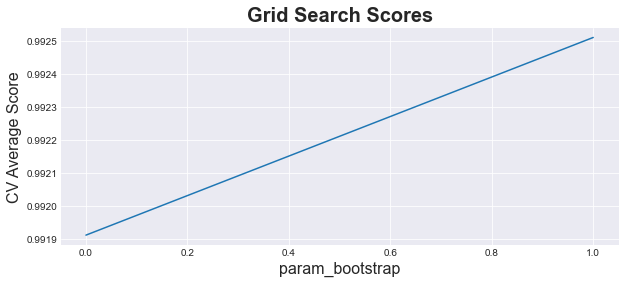

In [75]:
print(gd.best_params_)
trainer.plot_grid_search(gd.cv_results_, x='bootstrap', hue=None, log_scale = False)

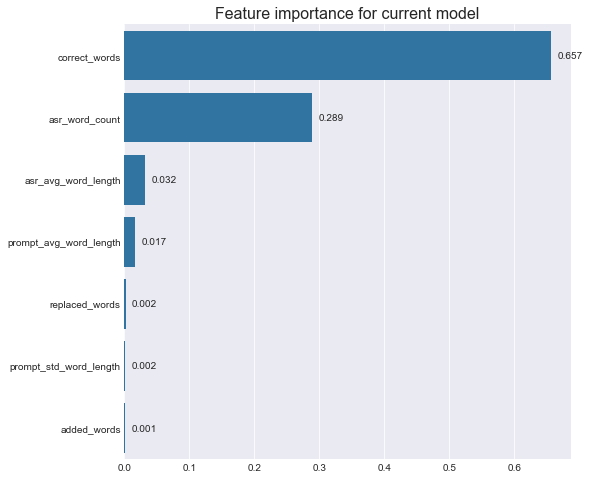

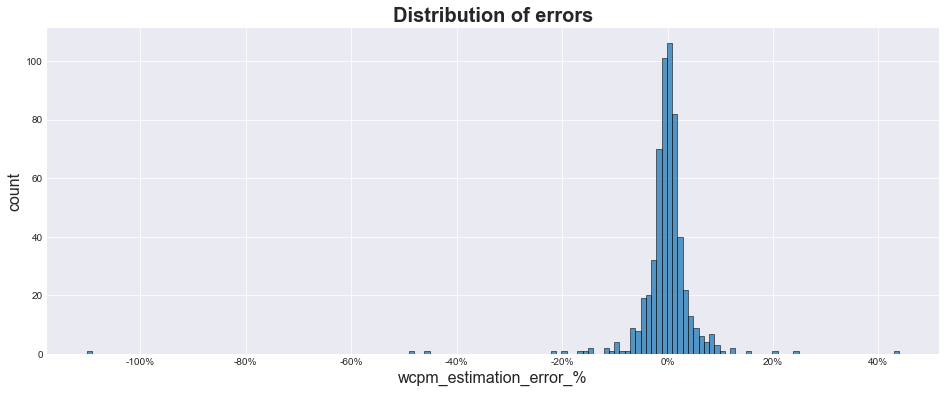

,Mean Error,Mean Error %,Mean abs. Error,Mean abs. Error %,RMSE,Error > 1%,Error > 5%,Error > 10%
mean,0.22,-0.00,2.46,2.82,4.66,NaN,NaN,NaN
std,4.66,0.07,3.96,6.24,13.43,NaN,NaN,NaN
absolute #,NaN,NaN,NaN,NaN,NaN,367.00,68.00,20.00
% of test set,NaN,NaN,NaN,NaN,NaN,63.72,11.81,3.47


In [78]:
trainer.feature_importance()
stats, summary = trainer.evaluate_model(visualize = True)
summary

In [82]:
trainer.save_model(scaler = False, model = True, replace = True)

2020-10-06 19:56:00,301 root         INFO     Saved file RF.joblib in dir ./literacy_score/models/
